In [1]:
#Import useful libraries
import ROOT
import dask
import os
import numpy as np
import math
import pandas
import glob
import sys
import tempfile
from ROOT import RooRealVar, RooBreitWigner, RooCBShape, RooFFTConvPdf, RooChebychev, RooAddPdf, RooDataHist, RooPlot, TCanvas, TPad, TH1, TF1
from ROOT import RooArgList
import time
import psutil 
from psutil import cpu_percent
import IPython 
import subprocess
#Dask libraries
from dask.distributed import LocalCluster, Client
from dask.distributed.client import _get_global_client
#%matplotlib notebook
from dask_kubernetes.operator import KubeCluster

Welcome to JupyROOT 6.30/02


In [2]:
# set up global variables                                                                                                                                                
fit_lowcut = 84.
fit_highcut = 98.
NbinsX = 50

nmaxiteration= 100
recreate_files= True

distributed = True

In [19]:
#cluster.close() # uncomment only if already have an open cluster

In [3]:
#Make an instance to dask clusters via Kubecluster

from dask_kubernetes.operator import KubeCluster

client = _get_global_client()

if client is not None:
    client.shutdown()


cluster = KubeCluster(
    # plug in the most suitable image 
    image='ghcr.io/ttedeschi/jlab:wp5-alma8-0.0.40',
    # set the number of the desired workers
    n_workers=10, 
    worker_command=[
        # set for example nthreads and memory parameters, based on the underlying infrastructure resources
        'dask-worker',
        '--name=$(DASK_WORKER_NAME)',
        '--local-directory=temp_dir', 
        '--nthreads', '2', 
        '--death-timeout', '60',
        '--memory-limit','4Gi' 
    ],
     
    resources={
        # initiate memory and CPU requests
        "requests": {
            "memory": "4Gi", 
            "cpu": "2" 
        },
        "limits": {
            # set memory and CPU limits, based on the underlying infrastructure resources
            "memory": "4Gi", 
            "cpu": "2" 
        }
    }
)
c_distributed = Client(cluster) # initialise a client to the cluster 
time.sleep(10)

Output()

In [4]:
c_distributed # have a look at your newly created distributed cluster info

<Client: 'tcp://10.42.3.99:8786' processes=8 threads=16, memory=32.00 GiB>

In [12]:
'''
# Specify the input file and its path
rootfile="ee_Z_ee_EDM4Hep.root"
inputpath="/opt/workspace/persistent-storage/RDataFrame_test/"
#inputpath="/opt/workspace/temp_dir/dask-scratch-space/"
file=inputpath+rootfile


# Function used to move the input file to the workers
def mv_file(file):
    path=glob.glob("/opt/workspace/temp_dir/dask-scratch-space/worker-*/")[0]
    subprocess.run(['mv', path+rootfile, "/opt/workspace/temp_dir/dask-scratch-space/"])


# Copy input files to the workers if you use a distributed approach
n_workers=len(c_distributed.scheduler_info()['workers'])

if distributed == True:
    c_distributed.wait_for_workers(n_workers)
    c_distributed.upload_file(inputpath+rootfile)
    c_distributed.wait_for_workers(n_workers)
    c_distributed.run(mv_file,rootfile) 
    c_distributed.wait_for_workers(n_workers)
    file=inputpath+rootfile
else:
    file = ROOT.TFile.Open(inputpath+rootfile)
         
    for a in file.GetListOfKeys():
        print(a)

'''

# Specify the input file and its path
rootfile="ee_Z_ee_EDM4Hep.root"
inputpath="/opt/workspace/persistent-storage/RDataFrame_test/"
inputpath_distr = "/opt/workspace/temp_dir/dask-scratch-space/"
#inputpath="/opt/workspace/temp_dir/dask-scratch-space/"
file=inputpath+rootfile


# Function used to move the input file to the workers
def mv_file(file):
    path=glob.glob("/opt/workspace/temp_dir/dask-scratch-space/worker-*/")[0]    
    subprocess.run(['mv',file, "../"])
    

# Copy input files to the workers if you use a distributed approach
n_workers=len(c_distributed.scheduler_info()['workers'])

if distributed == True:
    c_distributed.wait_for_workers(n_workers)
    c_distributed.upload_file(inputpath+rootfile)
    c_distributed.wait_for_workers(n_workers)
    c_distributed.run(mv_file,rootfile) 
    c_distributed.wait_for_workers(n_workers)
    file=inputpath_distr+rootfile
    print("file: ",file)
else:
    file = ROOT.TFile.Open(inputpath+rootfile)
         
    for a in file.GetListOfKeys():
        print(a) 

file:  /opt/workspace/temp_dir/dask-scratch-space/ee_Z_ee_EDM4Hep.root


In [13]:
# Specify the output folder where to store your results
outfolder = "/opt/workspace/persistent-storage/RDataFrame_test/output/mytest_Zee/"
if not os.path.exists(outfolder):
    os.mkdir(outfolder)

repohisto = outfolder+"plots/"
if not os.path.exists(repohisto):
    os.mkdir(repohisto)    

# Read utils functions    
text_file = open("/opt/workspace/persistent-storage/RDataFrame_test/utils/functions.h", "r")   
data = text_file.read()

In [14]:
# Define a class "variable" and append the kinematic properties of interest

class variable(object):
    def __init__(self, name, title, nbins=None, xmin=None, xmax=None):
        self._name = name
        self._title = title
        self._nbins = nbins
        self._xmin = xmin
        self._xmax = xmax
    def __str__(self):
        return  '\"'+str(self._name)+'\",\"'+str(self._title)+'\",\"'+str(self._nbins)+','+str(self._xmin)+','+str(self._xmax)

my_vars = []

my_vars.append(variable(name = "e1_energy", title= "leading electron energy [GeV]", nbins = 50, xmin = 0, xmax=100))
my_vars.append(variable(name = "e2_energy", title= "sub leading electron energy [GeV]", nbins = 50, xmin = 0, xmax=100))
my_vars.append(variable(name = "m_ee", title= "Zee invariant mass, m_{ee} [GeV]", nbins = 50, xmin = 84, xmax=98))
my_vars.append(variable(name = "dRee", title= "dRee, dR_{ee}", nbins = 50, xmin = 0, xmax=10))

In [15]:
# Initialization function
def my_initialization_function():
    print(ROOT.gInterpreter.ProcessLine(".O"))
    ROOT.gInterpreter.Declare('{}'.format(data))
    print("end of initialization")

# Function used to fit the invariant mass of the Z boson and extract the mean and resolution parms 
def myGetFitParameters(map_histog, mean_bw, input_width, input_sigma, path, m_sf, NbinsX, fit_lowcut, fit_highcut):
    parameters = []

    x = RooRealVar("x", "x", fit_lowcut, fit_highcut)                                                                                          
    x.setBins(10000, "cache")
    x.setMin("cache", 64.)
    x.setMax("cache", 118.)

    m0 = RooRealVar("m0", "m0", mean_bw, fit_lowcut, fit_highcut)                                                                                       
    width = RooRealVar("width", "width", input_width, 1., 4.)
    bw = RooBreitWigner("bw", "bw", x, m0, width)

    mean = RooRealVar("mean", "mean", 0.)
    sigma = RooRealVar("sigma", "sigma", input_sigma, 1., 5.)
    alpha = RooRealVar("alpha", "alpha", 1.3)
    n = RooRealVar("n", "n", 5.1)
    cb = RooCBShape("cb", "cb", x, mean, sigma, alpha, n)

    pdf_sig = RooFFTConvPdf("pdf_sig", "pdf_sig", x, bw, cb)
    coef0 = RooRealVar("c0", "coefficient #0", 1.0, -.01, 0.01)
    coef1 = RooRealVar("c1", "coefficient #1", -0.1, -.01, 0.01)
    coef2 = RooRealVar("c2", "coefficient #2", -0.1, -.01, 0.01)
    bkg1 = RooChebychev("bkg1", "bkg1", x, RooArgList(coef0, coef1, coef2))
    fsig = RooRealVar("fsig", "signal fraction", 0.9, 0., 1.)
    pdf = RooAddPdf("pdf", "pdf", RooArgList(pdf_sig, bkg1), RooArgList(fsig))
    histo = RooDataHist("histo", "histo", x, Import=map_histog)
    x.setRange("signal", fit_lowcut, fit_highcut)

    ROOT.Math.MinimizerOptions.SetDefaultMinimizer("Minuit2")
    ROOT.Math.MinimizerOptions.SetDefaultTolerance(0.0000001)
    ROOT.Math.MinimizerOptions.SetDefaultPrecision(0.0000001)

    pdf.fitTo(histo, SumW2Error=True, Range="signal")

    canv = ROOT.TCanvas("canv", "canv", 800, 600)
    frame1 = x.frame(Bins=NbinsX, Title="Convolution of a Breit-Wigner and a Crystal-Ball, Chebychev pol. bkg")
    histo.plotOn(frame1, Name="Data")
    pdf.plotOn(frame1, Name="pdf", LineColor=ROOT.kRed)
    pdf.paramOn(frame1, Layout=0.60)
    pdf.plotOn(frame1, Components="bkg1", LineStyle=ROOT.kDotted, LineColor=ROOT.kBlue)

    canvas = TCanvas("canvas", "canvas", 800, 600)
    canvas.cd()
    pad1 = TPad("pad1", "pad1name", 0.01, 0.31, 0.99, 0.99)
    pad2 = TPad("pad2", "pad2name", 0.01, 0.01, 0.99, 0.41)
    pad1.Draw()
    pad2.Draw()
    pad1.cd()
    pad1.SetBottomMargin(0.16)
    pad2.SetBottomMargin(0.24)
    frame1.GetYaxis().SetTitleOffset(1.4)
    frame1.GetXaxis().SetTitle("m_ee [GeV], sf_"+str(i_sf))
    frame1.Draw()
    pad1.Modified()
    pad1.RedrawAxis()
    pad1.Update()
    pad2.cd()

    tf1_model = pdf.asTF(x)
    clone_data = histo.createHistogram("clone_data",x,Binning=(NbinsX,fit_lowcut,fit_highcut))
    pdfHisto_data = pdf.generateBinned({x}, 1000000)
    clone_fit_data = pdfHisto_data.createHistogram("clone_fit_data",x,Binning=(NbinsX,fit_lowcut,fit_highcut))
    clone_fit_data.Scale(clone_data.Integral()/clone_fit_data.Integral())

    pdfHisto = pdf_sig.generateBinned({x}, 1000000)
    clone_fit = pdfHisto.createHistogram("clone_fit",x,Binning=(NbinsX,fit_lowcut,fit_highcut))
    clone_fit.Scale(clone_data.Integral()/clone_fit.Integral())
    
    x1 = fit_lowcut
    x2 = fit_highcut
    bin1 = clone_data.FindBin(x1)
    bin2 = clone_data.FindBin(x2)

    for i in range(0,clone_data.GetNbinsX() + 1):
        if i < bin1:
            clone_data.SetBinContent(i, 0.)
        if i > bin2:
            clone_data.SetBinContent(i, 0.)


    clone_data.Divide(clone_fit_data)

    clone_data.GetXaxis().SetTitle("m_ee [GeV], sf_"+str(i_sf))
    clone_data.GetYaxis().SetTitle("DATA / FIT")
    clone_data.GetXaxis().SetRangeUser(fit_lowcut, fit_highcut)
    clone_data.GetYaxis().SetRangeUser(0., 2.)
    clone_data.GetXaxis().SetLabelSize(0.1)
    clone_data.GetYaxis().SetLabelSize(0.08)
    clone_data.GetXaxis().SetTitleSize(0.08)
    clone_data.GetYaxis().SetTitleSize(0.09)
    clone_data.GetYaxis().SetTitleOffset(0.6)
    clone_data.GetXaxis().SetTitleOffset(1.2)
    clone_data.Draw("E1")
    pad2.Modified()
    pad2.SetGridy()
    pad2.RedrawAxis()
    pad2.Update()

    output_folder = path + "FitPlots"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    canvas.SaveAs(path + "FitPlots/sf_"+str(i_sf)+".pdf")
    canvas.SaveAs(path + "FitPlots/sf_"+str(i_sf)+".root")

    modelMean = tf1_model.GetMaximumX()

    parameters.append(modelMean)  # 0                                                                                                                            
    parameters.append(m0.getError())  # 1                                                                                                                        
    parameters.append(m0.getVal())  # 2                                                                                                                          
    parameters.append(sigma.getVal())  # 3  
    parameters.append(sigma.getError())  # 4                                                                                                                     
    parameters.append(mean.getVal())  # 5                                                                                                                        
    parameters.append(mean.getError())  # 6                                                                                                                      
    parameters.append(alpha.getVal())  # 7                                                                                                                       
    parameters.append(alpha.getError())  # 8                                                                                                                     
    parameters.append(n.getVal())  # 9                                                                                                                           
    parameters.append(n.getError())  # 10                                                                                                                        
    parameters.append(width.getVal())  # 11                                                                                                                      
    parameters.append(width.getError())  # 12                                                                                                                    
                                                                                                                                      
    del frame1
    del clone_data
    del clone_fit
    del pad1
    del pad2

    return parameters

In [16]:

# Function used to book the histos
def bookhisto(df, var, nmaxiteration):
    h_ = {}
    
    for i_sf in range(0,nmaxiteration):
        for v in var:           
            h_[v._name+"_"+str(i_sf)]= df.Histo1D(ROOT.RDF.TH1DModel(v._name+"_"+str(i_sf), v._title+"; Events", v._nbins, v._xmin, v._xmax), v._name+"_"+str(i_sf))
        
    print("Done bookhisto!")
    return h_    


# Function used to save the histos
def savehisto(h, var, nmaxiteration, repohisto):
    label="m_ee_test"
    
    Z_resolution = []
    dr = []
    max_pt_e1 = []
    max_pt_e2 = []  
    
    if recreate_files== True:
        outfile = ROOT.TFile.Open(repohisto+label+'.root', "RECREATE")   
    else:
        outfile = ROOT.TFile.Open(repohisto+label+'.root', "Update")   
    
    for i_sf in range(0,nmaxiteration):

        for v in var:
            tmp = h[v._name+"_"+str(i_sf)].GetValue()
            outfile.cd()
            tmp.Write()
            tmp.Sumw2()
            if v._name == "m_ee":
                Z_resolution.append(myGetFitParameters(tmp, tmp.GetMean(),width_mass_mc, sigma_mass_mc, outfolder, i_sf, NbinsX, fit_lowcut, fit_highcut)[3])
            if v._name == "dRee":
                binmax = tmp.GetMaximumBin()
                max_dr = tmp.GetXaxis().GetBinCenter(binmax)
                dr.append(max_dr)
            if v._name == "e1_energy":
                binmax = tmp.GetMaximumBin()
                max_e1 = tmp.GetXaxis().GetBinCenter(binmax)
                max_pt_e1.append(tmp.GetMean()) 
            if v._name == "e2_energy":
                binmax = tmp.GetMaximumBin()
                max_e2 = tmp.GetXaxis().GetBinCenter(binmax)
                max_pt_e2.append(tmp.GetMean())
  
    
    # Make 2D histos
    histogram1 = ROOT.TH2F("histogram_e1", "Resolution versus leading el pT;Z_{ee} resolution;Leading el p_{T} [GeV]", 100, 2.5, 5.5, 100, 45.4, 45.6)
    histogram2 = ROOT.TH2F("histogram_e2", "Resolution versus sub-leading el pT;Z_{ee} resolution;Sub-Leading el p_{T} [GeV]", 100, 2.5, 5.5, 100, 45.4, 45.6)
    
    print('lenght Z resol vect ', len(Z_resolution))
    # Fill 2D histos with array elements
    for i in range(len(Z_resolution)):
        histogram1.Fill(Z_resolution[i], max_pt_e1[i])
        histogram2.Fill(Z_resolution[i], max_pt_e2[i])

    histogram1.Write() 
    histogram2.Write()

    outfile.Close()
    

0
end of initialization
Dask client configured
Done bookhisto!
lenght Z resol vect  100


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

In file included from /opt/conda/include/module.modulemap:331:
input_line_111:59:7: error: redefinition of 'ComputeInvariantMass'
float ComputeInvariantMass(Vec_t px, Vec_t py, Vec_t pz, Vec_t e) {                                                                                              
      ^
input_line_68:59:7: note: previous definition is here
float ComputeInvariantMass(Vec_t px, Vec_t py, Vec_t pz, Vec_t e) {                                                                                              
      ^
In file included from /opt/conda/include/module.modulemap:331:
input_line_111:66:7: error: redefinition of 'ComputeEnergy'
RVecF ComputeEnergy(Vec_t px, Ve

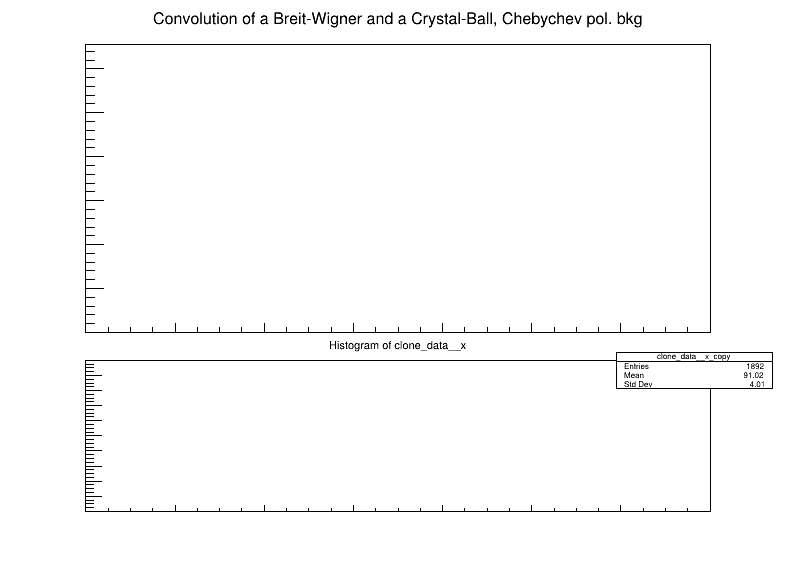

In [17]:
#MAIN         


# set up everything properly

nmaxpartition = 35 # optimise it in your case

# Make an instance to ROOT dataframe
if distributed == True:
    RDataFrame = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame
    ROOT.RDF.Experimental.Distributed.initialize(my_initialization_function)
else:
    RDataFrame = ROOT.RDataFrame
    my_initialization_function()


# Create an RDataFrame that will use Dask as a backend for computations
if distributed==True:      
    df = RDataFrame("events", file, npartitions=nmaxpartition,daskclient=c_distributed)
    
else:
    df = RDataFrame("events", file)

    
    
if distributed:
    # Check that you really made an instance to a distributed cluster and check the CPU usage per worker
    if isinstance(c_distributed, Client):
        print("Dask client configured")
    else:
        print("Warning! Dask client not configured properly!")    


        

var = my_vars
    
df = df.Define('w_nominal', '1')
df = df.Define("m_e","0.0005124") #GeV                                                                                                                           

df_ge = df.Define("goodelectrons", "Particle.charge[0]*Particle.charge[1] < 0.").Filter("goodelectrons > 0")


# start measuring time
start_time = time.time()


width_mass_mc = 2.49 #GeV                                                                                                                                        
sigma_mass_mc = 2.6 #GeV                                                                                                                                         


df_Mee = df_ge


# For each iteration, make your selection cuts and create dataframes
for i_sf in range(0,nmaxiteration):

    df_Mee = df_Mee.Define("m_ee_"+str(i_sf), "ComputeInvariantMass(Particle.momentum.x, Particle.momentum.y, Particle.momentum.z, ComputeEnergy(Particle.momentum.x, Particle.momentum.y, Particle.momentum.z,m_e))")
    df_Mee = df_Mee.Define("e1_energy_"+str(i_sf),"ComputeEnergy(Particle.momentum.x, Particle.momentum.y, Particle.momentum.z,m_e)[0]")
    df_Mee = df_Mee.Define("e2_energy_"+str(i_sf),"ComputeEnergy(Particle.momentum.x, Particle.momentum.y, Particle.momentum.z,m_e)[1]")
    df_Mee = df_Mee.Define("dRee_"+str(i_sf),"ComputeDRee(Particle.momentum.x, Particle.momentum.y, Particle.momentum.z,m_e)")
    print(df_Mee)

# Book and save the histos    
tmp=bookhisto(df_Mee, var, nmaxiteration)

savehisto(tmp, var, nmaxiteration, repohisto)

# end elapsed time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time




    

In [18]:
print("Tempo impiegato in secondi: ", elapsed_time)

Tempo impiegato in secondi:  178.34582543373108


In [ ]:
cluster.close()

In [ ]:
print('ciao')